# Initial Investigations: Neural Networks with Uncertainty


This notebook explores building neural networks that provide uncertainty measures and evaluates metrics that leverage those uncertainty measures to assess the model’s accuracy and robustness.

Uncertainty measures collected in this notebook include:
* *complement of the confidence score*: measures the complement of the model's maximum softmax probability, used as a proxy for certainty.
* *predictive entropy*: measures the overall uncertainty in the predicted class distribution.
* *predictive standard deviation*: captures variability over multiple stochastic predictions.

Note that the first two measures require a single prediction for each test input, while the third one requires multiple predictions for the same test input, e.g., coming from **Monte Carlo Dropout** or **Ensemble**.

These measures are used to define the following uncertainty based metrics:
* *Area Under Uncertainty Receiver Operating Characteristic curve (AU-UROC)*: measures how well uncertainty separates correct and incorrect predictions. The ROC curve is constructed by varying a threshold on the uncertainty scores:
    - Unknown on wrong rate: fraction of incorrect predictions flagged as unknown (i.e., uncertainty above the threshold).
    - Unknown on correct rate: fraction of correct predictions flagged as unknown.
* *Thresholded Accuracy*: computes the accuracy only with the predictions for which the uncertainty is under a user defined threshold.
* *Uncertainty Weighted Accuracy*: computes a weighted accuracy where correct predictions are down-weighted and incorrect predictions are up-weighted based on uncertainty.

*Traditional* accuracy is also included as a baseline.

Two additional metrics thath shift the perspective from uncertainty to certainty and that can be interpreted as mathematical operations between geometrical areas are proposed:
* *Aggregate Certainty-Uncertainty Area (ACUA)*: the sum between the area under the correct certainty curves and the area above the incorrect certainty curves, normalized in [0, 1]. Equivalent to the *Uncertainty Weighted Accuracy* metric.
* *Net Certainty Area (NCA)*: the difference between the area under the correct certainty curves and the area under the incorrect certainty curves, normalized in [0, 1].

The proposed metrics could be used to compute the model's robustness under distributional shifts or data corruption.

## Importing all the libraries
This section imports all required libraries for building and evaluating neural networks, handling data, and computing uncertainty measures and metrics. The core libraries include TensorFlow/Keras for modeling and NumPy for numerical operations.

In [429]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Flatten, Conv2D, AveragePooling2D, Dense, Dropout
from keras.datasets.mnist import load_data
from keras.utils import to_categorical
from keras.models import clone_model, load_model
from tabulate import tabulate


## Loading MNIST dataset
The MNIST handwritten digit dataset is loaded and preprocessed. The input images are normalized to the range [0, 1], and the target labels are one-hot encoded to work with categorical cross-entropy loss. Since the LeNet-5 architecture expects 32x32 grayscale images, the original 28x28 MNIST images are zero-padded to this size and reshaped to include a single channel dimension, resulting in inputs of shape (32, 32, 1).

In [430]:
(x_train, y_train), (x_test, y_test) = load_data()
# Normalize the data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Pad 2 pixels on each side (top, bottom, left, right)
x_train = np.pad(x_train, ((0,0), (2,2), (2,2)), 'constant')
x_test = np.pad(x_test, ((0,0), (2,2), (2,2)), 'constant')
# Add channel dimension for Conv2D
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
# Convert labes to categorical
n_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)
# Print dataset info
print(f"Training samples: {x_train.shape[0]}, Test samples: {x_test.shape[0]}")
print(f"Number of classes: {n_classes}")

Training samples: 60000, Test samples: 10000
Number of classes: 10


## LeNet-5 model definition, compilation, and training
We usa a LeNet-5 variant that follows the original architecture in LeCun et al. (1998) except for three modifications:
1. C3 is fully connected to all S2 feature maps rather than using the original partial connection table.
This simplification is common in modern reimplementations because current hardware can easily handle the additional parameters, and it allows the network to learn optimal connection patterns directly.
2. The original Euclidean RBF output layer is replaced by a softmax layer, which is now the standard practice for multi-class classification and provides a direct probabilistic interpretation of outputs.
3. Following Gal & Ghahramani (2016), we add a Dropout layer before the last fully connected inner-product layer (F6), with probability 0.5. The dropout layer will be kept active at test time to perform Monte Carlo dropout.

### Saving and loading models utility methods

In [431]:
def save_models(models, model_dir):
    """
    Save a list of Keras models to the specified directory in .h5 format.
    Parameters:
        models (List[keras.Model]): Trained Keras models to save.
        model_dir (str): Path to the directory where models will be saved.
    """
    os.makedirs(model_dir, exist_ok=True)
    print(f"Saving {len(models)} models to '{model_dir}'...")
    for i, model in enumerate(models):
        model.save(f"{model_dir}/model_{i}.h5")
    print("Models saved")

def load_models(n_models, model_dir):
    """
    Load a list of Keras models from the specified directory.
    Parameters:
        n_models (int): Number of models to load.
        model_dir (str): Path to the directory where models are saved.
    Returns:
        List[keras.Model]: Loaded Keras models.
    """
    print(f"Loading {n_models} models from '{model_dir}'...")
    return [load_model(f"{model_dir}/model_{i}.h5") for i in range(n_models)]

def saved_models_exists(n_models, model_dir):
    """
    Check if all expected model files exist in the specified directory.
    Parameters:
        n_models (int): Number of models expected.
        model_dir (str): Path to the directory to check.
    Returns:
        bool: True if all model files exist, False otherwise.
    """
    return all(os.path.exists(f"{model_dir}/model_{i}.h5") for i in range(n_models))

In [432]:
original_model_dir = "original_model"
saved_original_exists = saved_models_exists(1, original_model_dir)
if saved_original_exists:
    model = load_models(1, original_model_dir)[0]

Loading 1 models from 'original_model'...


### Building the model

In [433]:
if not saved_original_exists:
    model = keras.Sequential([
        Conv2D(6, 5, input_shape=(32, 32, 1), activation='tanh', padding='valid'), # C1
        AveragePooling2D(2, strides=2), # S2
        Conv2D(16, 5, activation='tanh', padding='valid'), # C3
        AveragePooling2D(2, strides=2), # S4
        Conv2D(120, 5, activation='tanh', padding='valid'), # C5
        Flatten(),
        Dropout(0.5),
        Dense(84, activation='tanh'), # F6
        Dense(n_classes, activation='softmax') # OUTPUT
    ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)              

### Compiling the model

In [434]:
# Define compile config (used later for ensemble)
compile_config = {
    "optimizer" : "adam",
    "loss" : "categorical_crossentropy",
    "metrics" : ["accuracy"]
}
# Compile the model
if not saved_original_exists:
    model.compile(**compile_config)

### Training the model
The model is trained for a fixed number of epochs with an 80/20 training-validation split.

In [435]:
# Define training config (used later for ensemble)
train_config = {
    "epochs": 10,
    "batch_size": 64,
    "validation_split": 0.2,
    "shuffle": True,
    "verbose": 2
}
# Train the model
if not saved_original_exists:
    history = model.fit(x_train, y_train, **train_config)
    save_models([model], original_model_dir)

### Visualizing training progress

In [436]:
# Plot trainininng vs validation accuracy
if not saved_original_exists:
    plt.plot(history.history["accuracy"], label="Train acc")
    plt.plot(history.history["val_accuracy"], label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training vs Validation Accuracy")
    plt.show()

## Defining uncertainty measures
Each method computes uncertainty in a different way. The first two (i.e., complement of the max probability and entropy) operate on a single probability vector produced by a single prediction. The third one (i.e., standard deviation of max probabilities) require multiple prediction vectors, such as those generated from ensemble models or Monte Carlo Dropout.

In [437]:
def compute_confidence_complement(prediction):
    """
    Compute the complement of the model's confidence score (i.e., the maximum predicted probability).
    Parameters:
        prediction (np.ndarray): 1D array of class probabilities from a single prediction.
    Returns:
        float: 1 - max(probability), representing uncertainty. Higher values indicate lower confidence.
    """
    return 1 - max(prediction)

In [438]:
def compute_entropy(prediction, epsilon=1e-12):
    """
    Compute the normalized Shannon entropy of the class probability distribution.
    Parameters:
        prediction (np.ndarray): 1D array of class probabilities from a single prediction.
        epsilon (float): Small value added for numerical stability to avoid log(0). Default is 1e-12.
    Returns:
        float: Normalized entropy in [0, 1], representing uncertainty. Higher values indicate lower confidence.
    """
    prediction = np.clip(prediction, epsilon, 1.0)  # avoid log(0)
    entropy = -np.sum(prediction * np.log(prediction))/np.log(len(prediction))
    return entropy

In [439]:
def compute_std_of_max_probs(predictions):
    """
    Compute the standard deviation of the maximum class probabilities across multiple stochastic predictions for the same input.
    Parameters:
        predictions (np.ndarray): 2D array (num_runs x num_classes), each row is a probability vector from one prediction.
    Returns:
        float: Standard deviation of the max probabilities, representing uncertainty. Higher values indicate lower confidence.
    """
    max_probs = np.max(predictions, axis=1)
    standard_deviation = np.std(max_probs, axis=0)
    return standard_deviation

## Defining uncertainty-based metrics
After defining basic uncertainty measures (such as predictive entropy), we now introduce higher-level metrics that leverage uncertainty measures to assess model behavior.
The following uncertainty-based metrics are defined:
* *Area Under Uncertainty Receiver Operating Characteristic curve (AU-UROC)*
* *Thresholded Accuracy*
* *Uncertainty Weighted Accuracy*


In [440]:
def compute_accuracies(predictions, uncertainties, true_labels, threshold):
    """
    Compute three accuracy metrics:
    - Traditional accuracy (acc_traditional)
    - Accuracy with threshold (acc_thresholded): only for predictions with uncertainty < threshold
    - Uncertainty-weighted accuracy (acc_weighted): downweights correct predictions by uncertainty, upweights incorrect ones
    Parameters:
        predictions (np.ndarray): Predicted class probabilities (n_samples x n_classes)
        uncertainties (np.ndarray): Uncertainty scores for each prediction (n_samples,)
        true_labels (np.ndarray): One-hot encoded true labels (n_samples x n_classes)
        threshold (float): Uncertainty threshold used for filtering in acc_thresholded
    Returns:
        tuple: (acc_traditional, acc_thresholded, acc_weighted)
    """
    correct_predictions = np.array([
        1 if np.argmax(pred) == np.argmax(true) else 0 
        for pred, true in zip(predictions, true_labels)
    ])
    thresholded_correct = 0
    thresholded_total = 0
    weighted_sum = 0
    for i in range(len(correct_predictions)):
        correct = correct_predictions[i]
        uncertainty = uncertainties[i]
        # Uncertainty-weighted accuracy: downweight correct predictions, upweight incorrect ones
        weighted_sum += correct * (1 - uncertainty) + (1 - correct) * uncertainty
        # Accuracy with threshold: only count predictions under uncertainty threshold
        if uncertainty < threshold:
            thresholded_correct += correct
            thresholded_total += 1
    acc_traditional = np.mean(correct_predictions)
    acc_weighted = weighted_sum / len(correct_predictions)
    acc_thresholded = thresholded_correct / thresholded_total if thresholded_total > 0 else None
    return acc_traditional, acc_thresholded, acc_weighted

In [441]:
def print_accuracies(acc_traditional, acc_thresholded, acc_weighted):
    """
    Print the three accuracy metrics.
    Parameters:
        acc_traditional (float): Traditional accuracy.
        acc_thresholded (float or None): Accuracy with uncertainty < threshold. May be None if no predictions qualify.
        acc_weighted (float): Uncertainty-weighted accuracy.
    """
    print(f"Traditional accuracy:\t\t{acc_traditional*100:.2f}%")
    if acc_thresholded is not None: 
        print(f"Thresholded accuracy:\t\t{acc_thresholded*100:.2f}%")
    else:
        print(f"Thresholded accuracy:\t\tundefined")
    print(f"Uncertainty weighted accuracy:\t{acc_weighted*100:.2f}%")

In [442]:
def compute_uroc(predictions, uncertainties, true_labels, n_thresholds):
    """
    Compute an approximation of the Uncertainty ROC curve.
    Parameters:
        predictions (np.ndarray): Predicted class probabilities (n_samples x n_classes)
        uncertainties (np.ndarray): Uncertainty values for each prediction (n_samples,)
        true_labels (np.ndarray): One-hot encoded true labels (n_samples x n_classes)
        n_thresholds (int): Number of uncertainty thresholds to evaluate
    Returns:
        List[Tuple[float, float]]: List of (x, y) points where:
            x = fraction of correct predictions flagged as unknown
            y = fraction of incorrect predictions flagged as unknown
    """
    correct_predictions = np.array([
        1 if np.argmax(pred) == np.argmax(true) else 0 
        for pred, true in zip(predictions, true_labels)
    ])
    # The UROC and AU-UROC metrics are not defined when no prediction is correct or no prediction is incorrect
    if sum(correct_predictions) == len(correct_predictions) or sum(correct_predictions) == 0:
        return None
    # Computing the thresholds to be used (each threshold is a point of the curve)
    #thresholds = np.linspace(1.0, 0.0, num=n_thresholds + 1) # evenly spaced thresholds
    #thresholds = np.unique(uncertainties)[::-1]  # a threshold for each unique value of uncertainty (similar to sklear auroc)
    #thresholds = np.unique(uncertainties.round(decimals=2))[::-1] # round to reduce the number of points
    thresholds = np.quantile(uncertainties, np.linspace(1.0, 0.0, num=n_thresholds + 1)) # use quantile
    points = []
    for threshold in thresholds:
        unknown_mask = np.array([1 if u > threshold else 0 for u in uncertainties])
        correct_total = np.sum(correct_predictions)
        incorrect_total = len(correct_predictions) - correct_total
        unknown_on_correct = np.sum(unknown_mask * correct_predictions) if correct_total > 0 else 0
        unknown_on_incorrect = np.sum(unknown_mask * (1 - correct_predictions)) if incorrect_total > 0 else 0
        x = unknown_on_correct / correct_total if correct_total > 0 else 0
        y = unknown_on_incorrect / incorrect_total if incorrect_total > 0 else 0
        points.append((x, y))
    return points

In [443]:
def compute_auc(points):
    """
    Compute the area under the curve using the trapezoidal rule.
    Parameters:
        points (List[Tuple[float, float]]): curve points as (x, y) coordinates
    Returns:
        float: Area under the curve
    """
    # The AU-UROC metric is not defined when no prediction is correct or no prediction is incorrect
    if points is None:
        return None
    x, y = zip(*points)
    return np.trapz(np.array(y), np.array(x))

In [444]:
def plot_uroc(points, area=None):
    """
    Plot the Uncertainty ROC curve.
    Parameters:
        points (List[Tuple[float, float]]): ROC points as (x, y) coordinates
        area (float, optional): Area under the curve to display in the title
    """
    print("--- Area Under Uncertainty ROC ---")
    if points is None:
        print("The AU-UROC metrics is not defined when no prediction is correct or no prediction is incorrect")
        return
    x, y = zip(*points)
    plt.figure(figsize=(3, 3))
    plt.plot(x, y, marker="o", linestyle="-", linewidth=2)
    plt.fill_between(x, y, alpha=0.2)
    plt.xlabel("Unknown on correct rate")
    plt.ylabel("Unknown on incorrect rate")
    title = "Uncertainty ROC Curve"
    if area is not None:
        title += f"\nAU-UROC = {area * 100:.2f}%"
    plt.title(title)
    plt.grid(False)
    plt.show()

#### Certainty based graphical metrics
The following metrics shift the perspective from uncertainty to certainty, offering a strong visual interpretation of model behavior. They can be interpreted as mathematical operations between geometrical areas:
* *Aggregate Certainty-Uncertainty Area (ACUA)*
* *Net Certainty Area (NCA)*

The first metric (ACUA) corresponds exactly to the *Uncertainty Weighted Accuracy* (as defined above) when the area under the certainty curves is computed using the Riemann approximation. Although it is possible to compute these metrics using the trapezoidal rule, certain issues can arise, and the Riemann approximation should be preferred.

In [445]:
def compute_certainty_data(predictions, uncertainties, true_labels):
    """
    Compute certainty values for correct and incorrect predictions, sorted in ascending order.
    Parameters:
        predictions (np.ndarray): Predicted class probabilities (n_samples x n_classes)
        uncertainties (np.ndarray): Uncertainty scores for each prediction (n_samples,)
        true_labels (np.ndarray): One-hot encoded true labels (n_samples x n_classes)
    Returns:
        tuple:
            np.ndarray: Sorted certainties for correct predictions (ascending)
            np.ndarray: Sorted certainties for incorrect predictions (ascending)
    """
    certainties = 1 - np.array(uncertainties)
    correct_predictions = np.array([
        1 if np.argmax(pred) == np.argmax(true) else 0
        for pred, true in zip(predictions, true_labels)
    ])
    correct_certainties = certainties[correct_predictions == 1]
    incorrect_certainties = certainties[correct_predictions == 0]
    return np.sort(correct_certainties), np.sort(incorrect_certainties)


In [446]:
def compute_area_based_metrics(correct_certainties, incorrect_certainties):
    """
    Compute certainty-based graphical metrics using the Riemann sum approximation.
    The computed metrics are Aggregate Certainty–Uncertainty Area (ACUA) and Net Certainty Area (NCA)
    Parameters:
        correct_certainties (np.ndarray): Sorted certainties for correct predictions.
        incorrect_certainties (np.ndarray): Sorted certainties for incorrect predictions.
    Returns:
        tuple:
            float: ACUA (Aggregate Certainty–Uncertainty Area) using Riemann sum
            float: NCA (Net Certainty Area) using Riemann sum
    """
    n_correct, n_incorrect = len(correct_certainties), len(incorrect_certainties)
    total_area = n_correct + n_incorrect
    au_correct = np.sum(correct_certainties)
    au_incorrect = np.sum(incorrect_certainties)
    aa_incorrect = n_incorrect - au_incorrect
    acua = (au_correct + aa_incorrect) / total_area
    nca = 0.5 + ((au_correct - au_incorrect) / (2 * total_area))
    return acua, nca


In [447]:
def print_area_based_metrics(acua, nca):
    """
    Print certainty-based graphical metrics.
    Parameters:
        acua (float): Aggregate Certainty–Uncertainty Area (ACUA).
        nca (float): Net Certainty Area (NCA).
    Returns:
        None
    """
    print(f"\n--- Certainty Area Based Metrics ---")
    print(f"ACUA (Aggregate Certainty–Uncertainty Area):\t{acua * 100:.2f}%")
    print(f"NCA (Net Certainty Area):\t\t\t{nca * 100:.2f}%")


In [448]:
def plot_certainty_bars(correct_certainties, incorrect_certainties):
    """
    Plot a bar chart of certainty values for incorrect and correct predictions.
    Used for visual interpretation of certainty-based metrics (ACUA and NCA) computed using Riemann sum approximation.
    Parameters:
        correct_certainties (np.ndarray): Sorted certainties for correct predictions.
        incorrect_certainties (np.ndarray): Sorted certainties for incorrect predictions.
    Returns:
        None        
    """
    n_incorrect = len(incorrect_certainties)
    n_correct = len(correct_certainties)
    x_incorrect = np.arange(n_incorrect)
    x_correct = n_incorrect + np.arange(n_correct)
    plt.figure(figsize=(6, 3))
    if n_incorrect > 0:
        plt.bar(x_incorrect, incorrect_certainties, width=1.0, alpha=0.6, label="Incorrect predictions")
    if n_correct > 0:
        plt.bar(x_correct, correct_certainties, width=1.0, alpha=0.6, label="Correct predictions")
    plt.xlabel("Samples")
    plt.ylabel("Certainty")
    plt.title(f"Certainty Areas – Riemann Approximation")
    plt.legend(loc="lower right")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

##### Trapezoidal aproximation
The following two methods compute the ACUA and NCA metrics using the trapezoidal approximation rule and plot the area under the correct curve and above the incorrect curve (in descending order). Using Riemann approximation should be preferred.

In [449]:
def compute_trapezoidal_based_metrics(correct_certainties, incorrect_certainties, compute_auc):
    """
    Compute certainty-based graphical metrics using the trapezoidal rule.
    The computed metrics are Aggregate Certainty–Uncertainty Area (ACUA) and Net Certainty Area (NCA)
    Parameters:
        correct_certainties (np.ndarray): Sorted certainties for correct predictions.
        incorrect_certainties (np.ndarray): Sorted certainties for incorrect predictions.
        compute_auc (callable): Function that computes area via trapezoidal approximation
    Returns:
        tuple:
            float: ACUA (Aggregate Certainty–Uncertainty Area) using trapezoidal rule
            float: NCA (Net Certainty Area) using trapezoidal rule
    """
    n_correct, n_incorrect = len(correct_certainties), len(incorrect_certainties)
    total_area = n_correct + n_incorrect - 1
    x_correct = n_incorrect + np.arange(n_correct)
    x_incorrect = np.arange(n_incorrect)
    au_correct = compute_auc(zip(x_correct, correct_certainties)) if n_correct > 1 else 0
    au_incorrect = compute_auc(zip(x_incorrect, incorrect_certainties)) if n_incorrect > 1 else 0
    aa_incorrect = ((n_incorrect - 1) - au_incorrect) if n_incorrect > 1 else 0
    acua = (au_correct + aa_incorrect) / total_area
    nca = 0.5 + ((au_correct - au_incorrect) / (2 * total_area))
    return acua, nca

In [450]:
def plot_trapezoidal_certainty_areas(correct_certainties, incorrect_certainties):
    """
    Plot certainty curves with shaded regions for incorrect and correct predictions.
    Used for visual interpretation of certainty-based metrics (ACUA and NCA) computed using trapezoidal rule.
    Parameters:
        correct_certainties (np.ndarray): Sorted certainties for correct predictions.
        incorrect_certainties (np.ndarray): Sorted certainties for incorrect predictions.
    Returns:
        None
    """
    n_correct, n_incorrect = len(correct_certainties), len(incorrect_certainties)
    x_incorrect = np.arange(n_incorrect)
    x_correct = n_incorrect + np.arange(n_correct)
    plt.figure(figsize=(6, 3))
    if len(incorrect_certainties) > 0:
        reversed_incorrect = incorrect_certainties[::-1]
        plt.plot(x_incorrect, reversed_incorrect, marker="o", markersize=1, linewidth=2, label="Incorrect predictions")
        plt.fill_between(x_incorrect, reversed_incorrect, 1, alpha=0.2)
    if len(correct_certainties) > 0:
        plt.plot(x_correct, correct_certainties, marker="o", markersize=1, linewidth=2, label="Correct predictions")
        plt.fill_between(x_correct, correct_certainties, alpha=0.2)
    if len(correct_certainties) > 0 and len(incorrect_certainties) > 0:
        plt.axvline(len(incorrect_certainties) - 0.5, color="gray", linestyle="--", linewidth=1)
    plt.xlabel("Samples")
    plt.ylabel("Certainty")
    plt.title(f"Certainty Areas – Treapezoidal Approximation")
    plt.legend(loc="lower right")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

## Training ensemble models
To estimate uncertainty using ensemble methods, multiple neural networks with the same architecture but different random initializations are trained. Each model is trained independently on the same dataset.

In [451]:
def train_ensemble_models(base_model, x_train, y_train, compile_config, train_config, n_models):
    """
    Train an ensemble of models independently using the same architecture and training configuration.
    Parameters:
        base_model (keras.Model): An untrained base model to replicate.
        x_train (ndarray): Training input data.
        y_train (ndarray): Training labels.
        compile_config (dict): Dictionary of compile arguments (e.g., optimizer, loss, metrics).
        train_config (dict): Dictionary of training arguments (e.g., epochs, batch_size).
        n_models (int): Number of models to train in the ensemble.
    Returns:
        List[keras.Model]: A list of trained Keras models, each trained independently.
    """
    models = []
    for i in range(n_models):
        print(f"-- Training model {i + 1}/{n_models} --")
        model = clone_model(base_model)
        model.compile(**compile_config)
        model.fit(x_train, y_train, **train_config)
        models.append(model)
    return models

In [452]:
ensemble_dir = "ensemble_models"
n_models = 5
if saved_models_exists(n_models, ensemble_dir):
    ensamble_models = load_models(n_models, ensemble_dir)
else:
    ensamble_models = train_ensemble_models(model, x_train, y_train, compile_config, train_config, n_models)
    save_models(ensamble_models, ensemble_dir)

Loading 5 models from 'ensemble_models'...


## Applying uncertainty measures and uncertainty based metrics
In this section, we apply the previously defined uncertainty measures and metrics to analyze the behavior of the trained model on the MNIST dataset.

### Uncertainty measures

In [453]:
# Get softmax predictions from a single deterministic prediction (used for entropy and max complement)
predictions = model.predict(x_test)
print(f"Single-pass predictions shape: {predictions.shape}")

Single-pass predictions shape: (10000, 10)


In [454]:
# Generate multiple stochastic predictions using Monte Carlo Dropout
n_mc_passes  = 5
mc_predictions = np.array([model(x_test, training=True) for _ in range(n_mc_passes)])
print(f"MC Dropout predictions shape: {mc_predictions.shape}")  # Expect (n_mc_passes, n_samples, n_classes)

MC Dropout predictions shape: (5, 10000, 10)


In [455]:
# Generate predictions from each model in the ensemble
ensemble_predictions = np.array([model(x_test, training=False) for model in ensamble_models])
print(f"Ensemble predictions shape: {ensemble_predictions.shape}")  # Expect (n_models, n_samples, n_classes)

Ensemble predictions shape: (5, 10000, 10)


In [456]:
# Extract predicted and true class labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
# Compute uncertainty scores for single-pass predictions
uncertainty_confidence_complement = np.array([compute_confidence_complement(p) for p in predictions])
uncertainty_entropy = np.array([compute_entropy(p) for p in predictions])
# Compute MC Dropout-based uncertainty (std of max probs over multiple runs)
mean_mc_predictions = np.mean(mc_predictions, axis=0)
mc_predicted_labels = np.argmax(mean_mc_predictions, axis=1)
mc_predictions_stacked = np.moveaxis(mc_predictions, 1, 0) # Group predictions by sample
uncertainty_mc_dropout = np.array([compute_std_of_max_probs(p) for p in mc_predictions_stacked])
uncertainty_mc_dropout_entropy = np.array([compute_entropy(p) for p in mean_mc_predictions])
# Compute Ensemble-based uncertainty (std of max probs over ensemble members)
mean_ensemble_predictions = np.mean(ensemble_predictions, axis=0)
ensemble_predicted_labels = np.argmax(mean_ensemble_predictions, axis=1)
ensemble_predictions_stacked = np.moveaxis(ensemble_predictions, 1, 0) # Group predictions by sample
uncertainty_ensemble = np.array([compute_std_of_max_probs(p) for p in ensemble_predictions_stacked])
uncertainty_ensemble_entropy = np.array([compute_entropy(p) for p in mean_ensemble_predictions])
# Print quick summary of average uncertainties
print("\nMean uncertainty scores:")
print(f"  Confidence Complement:      {np.mean(uncertainty_confidence_complement)*100:.2f}%")
print(f"  Entropy:                    {np.mean(uncertainty_entropy)*100:.2f}%")
print(f"  MC Dropout - max probs std: {np.mean(uncertainty_mc_dropout)*100:.2f}%")
print(f"  MC Dropout - mean entropy:  {np.mean(uncertainty_mc_dropout_entropy)*100:.2f}%")
print(f"  Ensemble - max probs std:   {np.mean(uncertainty_ensemble)*100:.2f}%")
print(f"  Ensemble - mean entropy:    {np.mean(uncertainty_ensemble_entropy)*100:.2f}%")


Mean uncertainty scores:
  Confidence Complement:      1.00%
  Entropy:                    1.38%
  MC Dropout - max probs std: 1.29%
  MC Dropout - mean entropy:  2.95%
  Ensemble - max probs std:   0.80%
  Ensemble - mean entropy:    1.80%


In [457]:
# Summarize uncertainty statistics
uncertainty_labels = ["Conf. Complement", "Entropy", "MC Dropout\nmax probs std", "MC Dropout\nmean entropy", "Ensemble\nmax probs std", "Ensemble\nmean entropy"]
uncertainty_measures = [
    uncertainty_confidence_complement,
    uncertainty_entropy,
    uncertainty_mc_dropout,
    uncertainty_mc_dropout_entropy,
    uncertainty_ensemble,
    uncertainty_ensemble_entropy
]
summary_data = [
    ["Uncertainty [%]"] + uncertainty_labels,
    ["Min"]  + [100*np.min(u) for u in uncertainty_measures],
    ["Max"]  + [100*np.max(u) for u in uncertainty_measures],
    ["Mean"] + [100*np.mean(u) for u in uncertainty_measures],
    ["Std"]  + [100*np.std(u) for u in uncertainty_measures],
]
print("Uncertainty Summary Statistics")
colalign = ("right",) + ("center",) * (len(summary_data[0]) - 1)
print(tabulate(summary_data, headers="firstrow", floatfmt=".2f", tablefmt="grid", colalign=colalign))

Uncertainty Summary Statistics
+-------------------+--------------------+-----------+-----------------+----------------+-----------------+----------------+
|   Uncertainty [%] |  Conf. Complement  |  Entropy  |   MC Dropout    |   MC Dropout   |    Ensemble     |    Ensemble    |
|                   |                    |           |  max probs std  |  mean entropy  |  max probs std  |  mean entropy  |
+===================+====================+===========+=================+================+=================+================+
|               Min |        0.00        |   0.01    |      0.00       |      0.03      |      0.00       |      0.01      |
+-------------------+--------------------+-----------+-----------------+----------------+-----------------+----------------+
|               Max |       65.68        |   63.67   |      25.53      |     72.44      |      24.75      |     71.07      |
+-------------------+--------------------+-----------+-----------------+----------------+-----

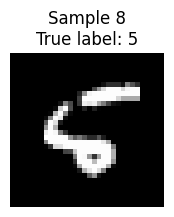

Uncertainty measures for sample 8:
  * Single prediction - predicted 6:
     - Max Complement = 41.16%
     - Entropy = 32.27%
  * MC Dropout - predicted 6:
     - Max probs std = 16.47%
     - Mean entropy = 32.90%
  * Ensemble - predicted 5:
     - Max probs std = 5.16%
     - Mean entropy = 10.62%


In [458]:
# Visualize the sample image with index 8 (found to be difficult to calssify)
sample_index = 8
plt.figure(figsize=(2, 2))  # Shrink the image display size
plt.imshow(x_test[sample_index].reshape(32, 32), cmap="gray")
plt.title(f"Sample {sample_index}\nTrue label: {true_labels[sample_index]}")
plt.axis("off")
plt.show()
# Print uncertainty measures and predictions
print(f"Uncertainty measures for sample {sample_index}:")
print(f"  * Single prediction - predicted {predicted_labels[sample_index]}:")
print(f"     - Max Complement = {uncertainty_confidence_complement[sample_index]*100:.2f}%")
print(f"     - Entropy = {uncertainty_entropy[sample_index]*100:.2f}%")
print(f"  * MC Dropout - predicted {mc_predicted_labels[sample_index]}:")
print(f"     - Max probs std = {uncertainty_mc_dropout[sample_index]*100:.2f}%")
print(f"     - Mean entropy = {uncertainty_mc_dropout_entropy[sample_index]*100:.2f}%")
print(f"  * Ensemble - predicted {ensemble_predicted_labels[sample_index]}:")
print(f"     - Max probs std = {uncertainty_ensemble[sample_index]*100:.2f}%")
print(f"     - Mean entropy = {uncertainty_ensemble_entropy[sample_index]*100:.2f}%")

### Uncertainty based metrics

In [459]:
def evaluate_uncertainty_metrics(name, predictions, uncertainties, true_labels, threshold, n_roc_points):
    """
    Evaluate a model's performance using uncertainty measures and metrics.
    Parameters:
        name (str): Name of the uncertainty method (for labeling output and plots)
        predictions (np.ndarray): Predicted class probabilities (n_samples x n_classes)
        uncertainties (np.ndarray): Uncertainty scores associated with each prediction (n_samples,)
        true_labels (np.ndarray): One-hot encoded ground truth labels (n_samples x n_classes)
        threshold (float): Uncertainty threshold for filtering predictions in accuracy-with-threshold
        n_roc_points (int): Number of thresholds to use for UROC curve approximation
    Returns:
        None
    """
    print(f"\n=== {name} ===")
    acc_trad, acc_thresh, acc_weighted = compute_accuracies(predictions, uncertainties, true_labels, threshold)
    print_accuracies(acc_trad, acc_thresh, acc_weighted)
    correct_certs, incorrect_certs = compute_certainty_data(predictions, uncertainties, true_labels)
    acua, nca = compute_area_based_metrics(correct_certs, incorrect_certs)
    print_area_based_metrics(acua, nca)
    plot_certainty_bars(correct_certs, incorrect_certs)
    roc_curve = compute_uroc(predictions, uncertainties, true_labels, n_roc_points)
    au_uroc = compute_auc(roc_curve)
    plot_uroc(roc_curve, area=au_uroc)

In [460]:
# Set parameters for evaluation
threshold = 0.2 # output is flagged as unknown if uncertainty > 20%
roc_n_points = 30

#### Single prediction


=== Confidence Complement ===
Traditional accuracy:		98.70%
Thresholded accuracy:		99.32%
Uncertainty weighted accuracy:	98.31%

--- Certainty Area Based Metrics ---
ACUA (Aggregate Certainty–Uncertainty Area):	98.31%
NCA (Net Certainty Area):			98.50%


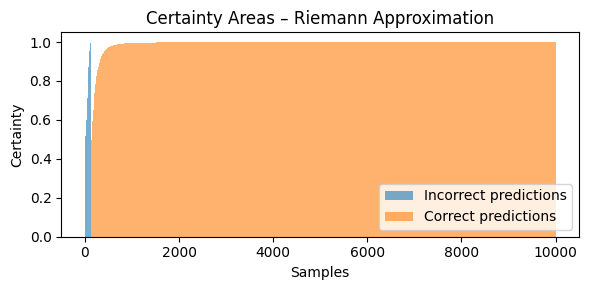

--- Area Under Uncertainty ROC ---


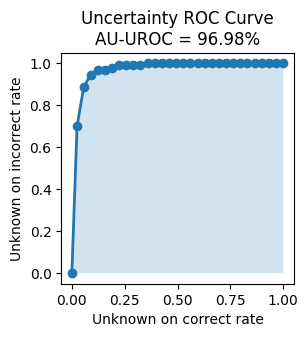

In [461]:
evaluate_uncertainty_metrics(
    name="Confidence Complement",
    predictions=predictions,
    uncertainties=uncertainty_confidence_complement,
    true_labels=y_test,
    threshold=threshold,
    n_roc_points=roc_n_points
)


=== Entropy ===
Traditional accuracy:		98.70%
Thresholded accuracy:		99.45%
Uncertainty weighted accuracy:	97.93%

--- Certainty Area Based Metrics ---
ACUA (Aggregate Certainty–Uncertainty Area):	97.93%
NCA (Net Certainty Area):			98.32%


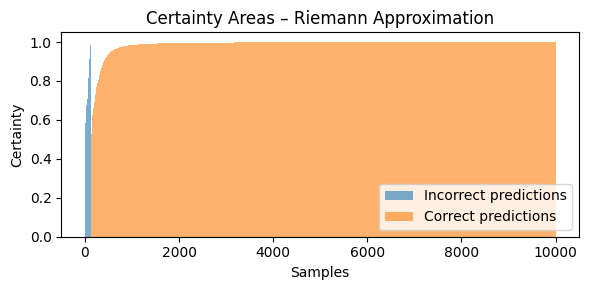

--- Area Under Uncertainty ROC ---


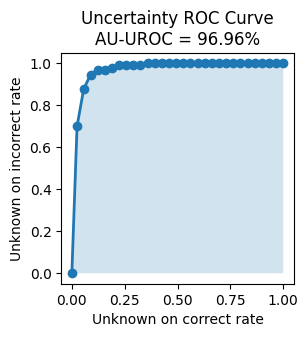

In [462]:
evaluate_uncertainty_metrics(
    name="Entropy",
    predictions=predictions,
    uncertainties=uncertainty_entropy,
    true_labels=y_test,
    threshold=threshold,
    n_roc_points=roc_n_points
)

#### MC Dropout


=== MC Dropout - max probs std ===
Traditional accuracy:		98.50%
Thresholded accuracy:		98.60%
Uncertainty weighted accuracy:	97.59%

--- Certainty Area Based Metrics ---
ACUA (Aggregate Certainty–Uncertainty Area):	97.59%
NCA (Net Certainty Area):			98.05%


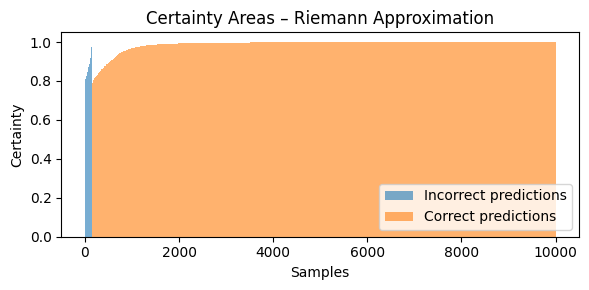

--- Area Under Uncertainty ROC ---


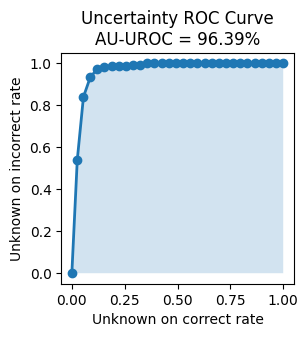

In [463]:
evaluate_uncertainty_metrics(
    name="MC Dropout - max probs std",
    predictions=mean_mc_predictions,
    uncertainties=uncertainty_mc_dropout,
    true_labels=y_test,
    threshold=threshold,
    n_roc_points=roc_n_points
)


=== MC Dropout - mean entropy ===
Traditional accuracy:		98.50%
Thresholded accuracy:		99.69%
Uncertainty weighted accuracy:	96.55%

--- Certainty Area Based Metrics ---
ACUA (Aggregate Certainty–Uncertainty Area):	96.55%
NCA (Net Certainty Area):			97.52%


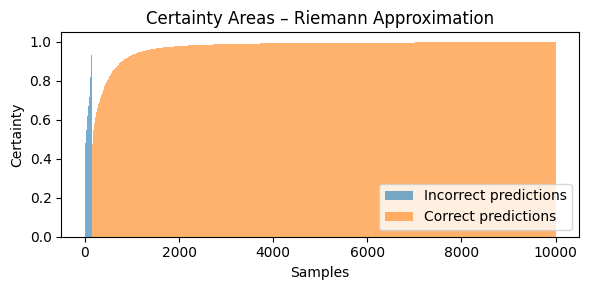

--- Area Under Uncertainty ROC ---


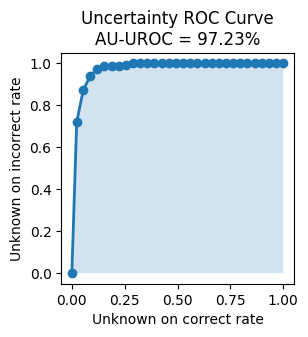

In [464]:
evaluate_uncertainty_metrics(
    name="MC Dropout - mean entropy",
    predictions=mean_mc_predictions,
    uncertainties=uncertainty_mc_dropout_entropy,
    true_labels=y_test,
    threshold=threshold,
    n_roc_points=roc_n_points
)

#### Ensemble


=== Ensemble - max probs std ===
Traditional accuracy:		98.92%
Thresholded accuracy:		98.96%
Uncertainty weighted accuracy:	98.38%

--- Certainty Area Based Metrics ---
ACUA (Aggregate Certainty–Uncertainty Area):	98.38%
NCA (Net Certainty Area):			98.65%


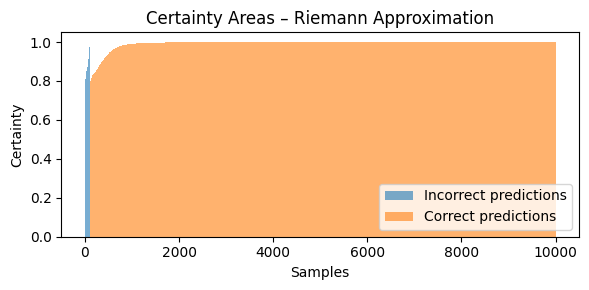

--- Area Under Uncertainty ROC ---


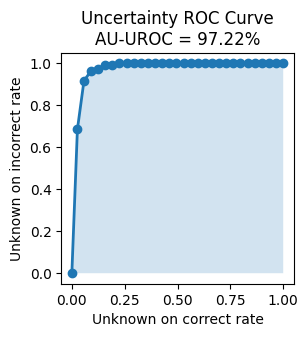

In [465]:
evaluate_uncertainty_metrics(
    name="Ensemble - max probs std",
    predictions=mean_ensemble_predictions,
    uncertainties=uncertainty_ensemble,
    true_labels=y_test,
    threshold=threshold,
    n_roc_points=roc_n_points
)


=== Ensemble - mean entropy ===
Traditional accuracy:		98.92%
Thresholded accuracy:		99.78%
Uncertainty weighted accuracy:	97.81%

--- Certainty Area Based Metrics ---
ACUA (Aggregate Certainty–Uncertainty Area):	97.81%
NCA (Net Certainty Area):			98.37%


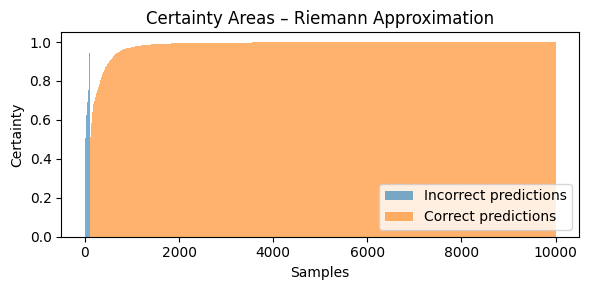

--- Area Under Uncertainty ROC ---


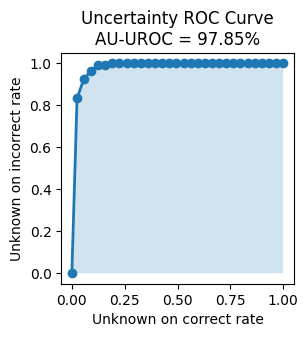

In [466]:
evaluate_uncertainty_metrics(
    name="Ensemble - mean entropy",
    predictions=mean_ensemble_predictions,
    uncertainties=uncertainty_ensemble_entropy,
    true_labels=y_test,
    threshold=threshold,
    n_roc_points=roc_n_points
)

#### Riemann vs Trapezoidal aproximations
The following evaluation shows the difference between the certainty-area based metrics when computed with the Riemann and trapezoidal aproximations using a reduced dataset of 25 images.  


--- Certainty Area Based Metrics ---
ACUA (Aggregate Certainty–Uncertainty Area):	92.37%
NCA (Net Certainty Area):			92.18%


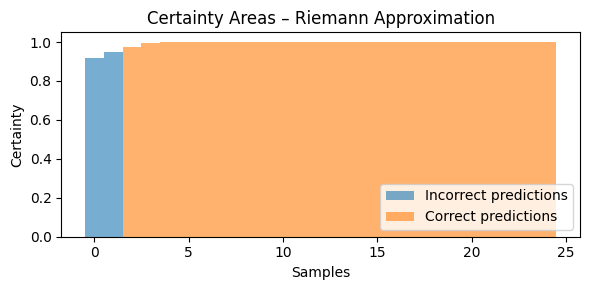


--- Certainty Area Based Metrics ---
ACUA (Aggregate Certainty–Uncertainty Area):	91.83%
NCA (Net Certainty Area):			93.83%


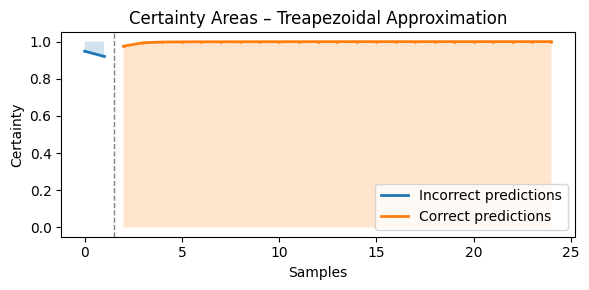

In [467]:
n = 25
r_predictions = predictions[:n]
r_uncertainties = uncertainty_ensemble[:n]
r_true_labels = y_test[:n]
correct_certs, incorrect_certs = compute_certainty_data(r_predictions, r_uncertainties, r_true_labels)
# Riemann
acua, nca = compute_area_based_metrics(correct_certs, incorrect_certs)
print_area_based_metrics(acua, nca)
plot_certainty_bars(correct_certs, incorrect_certs)
# Trapezoidal
acua, nca = compute_trapezoidal_based_metrics(correct_certs, incorrect_certs, compute_auc)
print_area_based_metrics(acua, nca)
plot_trapezoidal_certainty_areas(correct_certs, incorrect_certs)